In [3]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 19.1MB/s 
     |████████████████████████████████| 61kB 11.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 17.3MB/s 


In [4]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-03 15:21:32--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-03 15:21:33--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc88510ed4917bca0f251018ada7.dl.dropboxusercontent.com/cd/0/get/BJ9AqZ4ATELHj02CQ2wltQ59tF_HtOyUZsMRYlwc8YzLAO9D4LACcmgCiMRX6SlOI6HVoGyfxN-oNB7yS_LPBaDH8aT4x6_kxTQ4KEkoQ4RZVsxfD4hZQRGzpR9ZKsFb-E4/file?dl=1# [following]
--2021-03-03 15:21:33--  https://uc88510ed4917bca0f251018ada7.dl.dropboxusercontent.com/cd/0/get/BJ9AqZ4ATELHj02CQ2wltQ59tF_HtOyUZsMRYlwc8YzLAO9D4LACcmgCiMRX6SlOI6HVoGyfxN-oNB7yS_LPB

In [5]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [6]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [7]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [8]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [9]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [10]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [11]:
modelo='resnet34'

## Ranger

In [12]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [13]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


SuggestedLRs(lr_min=0.15848932266235352, lr_steep=1.4454397387453355e-05)

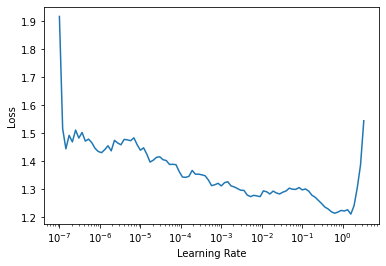

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.251422,0.936622,0.503058,0.520000,0.682216,00:25
1,1.276833,0.888013,0.512232,0.527397,0.673469,00:25


Better model found at epoch 0 with valid_loss value: 0.9366222620010376.


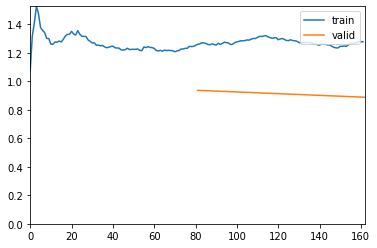

Better model found at epoch 1 with valid_loss value: 0.888013482093811.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.269286,0.879855,0.513761,0.527473,0.699708,00:27
1,1.228022,0.877633,0.519878,0.533958,0.664723,00:27
2,1.218256,0.859572,0.524465,0.536697,0.682216,00:27
3,1.214286,0.842145,0.533639,0.543779,0.688047,00:27
4,1.178402,0.817538,0.529052,0.543641,0.635569,00:27
5,1.159185,0.806743,0.553517,0.560570,0.688047,00:27
6,1.096055,0.787364,0.542813,0.556410,0.632653,00:27
7,1.122388,0.775200,0.555046,0.563725,0.670554,00:27
8,1.094432,0.785325,0.551988,0.560680,0.673469,00:27
9,1.090453,0.772122,0.548930,0.560302,0.650146,00:27


Better model found at epoch 0 with valid_loss value: 0.8798553943634033.


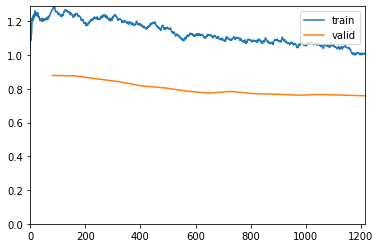

Better model found at epoch 1 with valid_loss value: 0.8776327967643738.
Better model found at epoch 2 with valid_loss value: 0.859571635723114.
Better model found at epoch 3 with valid_loss value: 0.8421452641487122.
Better model found at epoch 4 with valid_loss value: 0.8175383806228638.
Better model found at epoch 5 with valid_loss value: 0.8067432045936584.
Better model found at epoch 6 with valid_loss value: 0.7873644232749939.
Better model found at epoch 7 with valid_loss value: 0.7751998901367188.
Better model found at epoch 9 with valid_loss value: 0.7721217274665833.
Better model found at epoch 10 with valid_loss value: 0.7688310742378235.
Better model found at epoch 11 with valid_loss value: 0.7626709342002869.
Better model found at epoch 14 with valid_loss value: 0.7590516805648804.


In [15]:
learn.fine_tune(15,freeze_epochs=2)

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

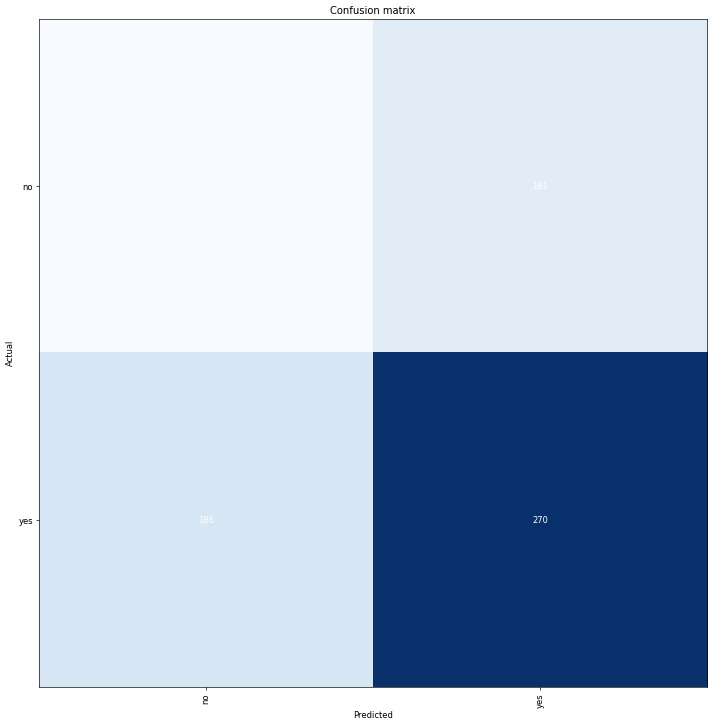

In [17]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5452292561531067.


(#4) [0.7878479361534119,0.5452292561531067,0.5986696230598669,0.5921052631578947]

## Faltten

In [19]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.291595,0.863420,0.573394,0.603896,0.542274,00:25
1,1.067544,0.759227,0.579511,0.607595,0.559767,00:25


Better model found at epoch 0 with valid_loss value: 0.8634201884269714.


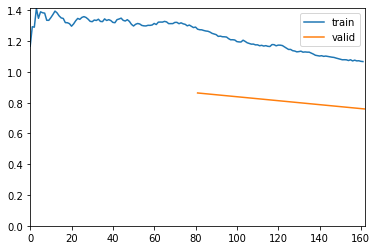

Better model found at epoch 1 with valid_loss value: 0.7592267990112305.


In [20]:
learn.fit_flat_cos(2,lr=1e-3)

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

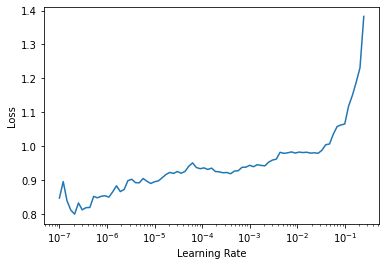

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.004765,0.709834,0.461774,0.468531,0.195335,00:26
1,1.021745,3.229470,0.524465,0.524465,1.000000,00:26
2,0.984435,2.536843,0.501529,0.515206,0.839650,00:26
3,1.054138,0.702490,0.525994,0.525268,1.000000,00:26
4,0.991062,1.126162,0.524465,0.524465,1.000000,00:26
5,1.109010,57.846592,0.475535,0.000000,0.000000,00:26
6,0.978928,23.837816,0.466361,0.312500,0.014577,00:26


Better model found at epoch 0 with valid_loss value: 0.7098336219787598.


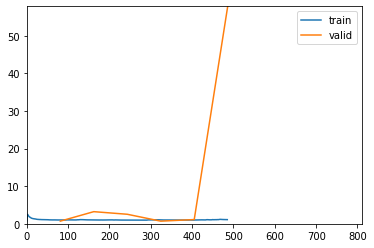

Better model found at epoch 3 with valid_loss value: 0.702489972114563.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 3: early stopping


In [23]:
learn.fit_flat_cos(10,lr=1e-2)

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

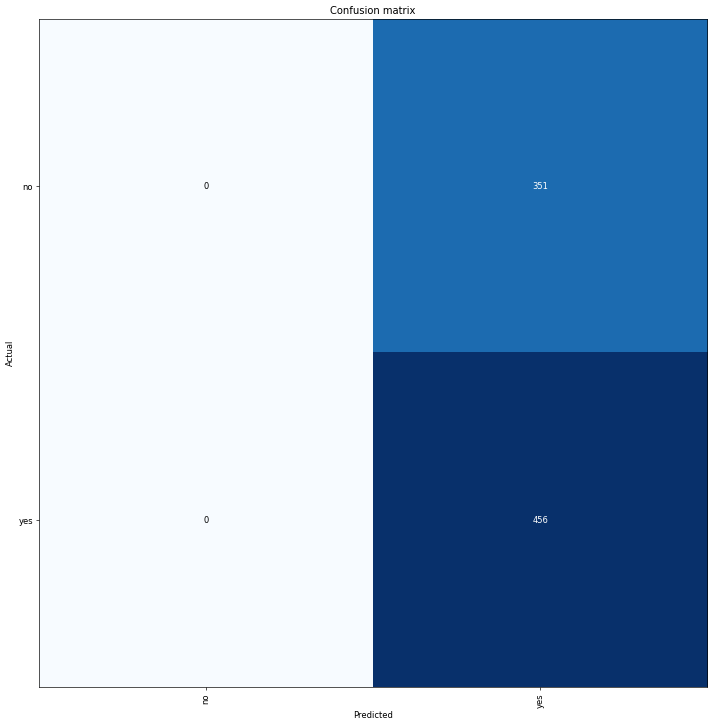

In [25]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6866334676742554,0.565055787563324,0.5650557620817844,1.0]

## LabelSmoothing

In [27]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=7.585775847473997e-07)

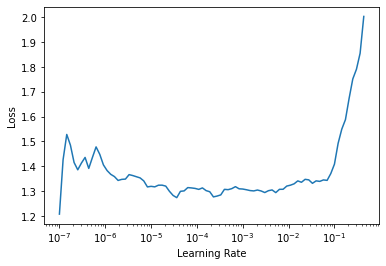

In [28]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.251467,0.912744,0.527523,0.570248,0.402332,00:24
1,1.078396,0.762455,0.555046,0.565000,0.658892,00:24


Better model found at epoch 0 with valid_loss value: 0.9127439856529236.


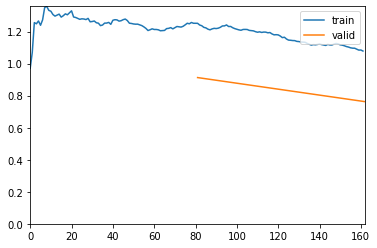

Better model found at epoch 1 with valid_loss value: 0.7624548077583313.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.821087,0.713625,0.570336,0.612319,0.492711,00:26
1,0.800160,0.714258,0.571865,0.569536,0.752187,00:26
2,0.761563,0.705010,0.565749,0.624473,0.431487,00:27
3,0.728574,0.677505,0.607034,0.626471,0.620991,00:26
4,0.715533,0.672670,0.591743,0.602151,0.653061,00:26
5,0.696789,0.660063,0.622324,0.628342,0.685131,00:26
6,0.687069,0.662634,0.610092,0.624294,0.644315,00:27
7,0.673617,0.678403,0.603976,0.690909,0.443149,00:27
8,0.652673,0.656082,0.628440,0.690840,0.527697,00:26
9,0.651272,0.664421,0.608563,0.718593,0.416910,00:27


Better model found at epoch 0 with valid_loss value: 0.7136250734329224.


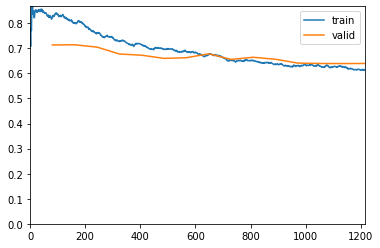

Better model found at epoch 2 with valid_loss value: 0.7050098776817322.
Better model found at epoch 3 with valid_loss value: 0.6775050759315491.
Better model found at epoch 4 with valid_loss value: 0.6726697087287903.
Better model found at epoch 5 with valid_loss value: 0.6600629687309265.
Better model found at epoch 8 with valid_loss value: 0.6560817360877991.
Better model found at epoch 11 with valid_loss value: 0.6411367654800415.
Better model found at epoch 12 with valid_loss value: 0.6397048234939575.
Better model found at epoch 13 with valid_loss value: 0.6393932700157166.


In [29]:
learn.fine_tune(15,freeze_epochs=2)

In [30]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

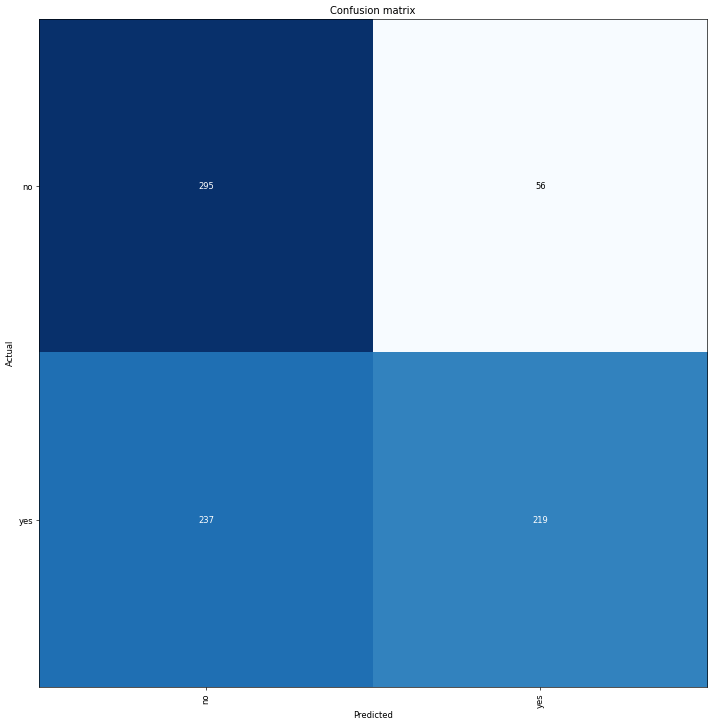

In [31]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [32]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6369268894195557.


(#4) [0.6498252153396606,0.6369268894195557,0.7963636363636364,0.48026315789473684]

## MixUp

In [37]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [41]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=6.309573450380412e-07)

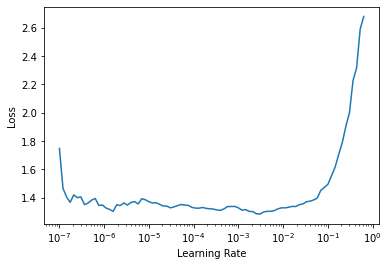

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.277029,0.974105,0.521407,0.551724,0.466472,00:24
1,1.120583,0.973243,0.532110,0.612121,0.294461,00:25


Better model found at epoch 0 with valid_loss value: 0.9741052389144897.


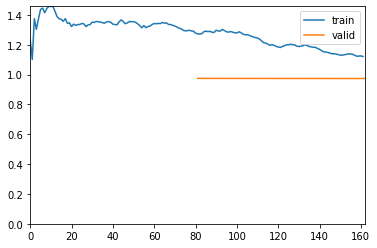

Better model found at epoch 1 with valid_loss value: 0.9732434749603271.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.899053,0.754650,0.564220,0.602837,0.495627,00:26
1,0.842074,0.729344,0.573394,0.584656,0.644315,00:26
2,0.798588,0.694596,0.584098,0.600000,0.620991,00:26
3,0.752367,0.710328,0.562691,0.612648,0.451895,00:26
4,0.729425,0.725996,0.532110,0.645669,0.239067,00:26
5,0.709741,0.684781,0.581040,0.639676,0.460641,00:26
6,0.705978,0.673604,0.585627,0.669811,0.413994,00:27
7,0.688918,0.661826,0.600917,0.639456,0.548105,00:26
8,0.675206,0.669351,0.591743,0.665217,0.446064,00:27
9,0.675770,0.642736,0.625382,0.667808,0.568513,00:27


Better model found at epoch 0 with valid_loss value: 0.7546504735946655.


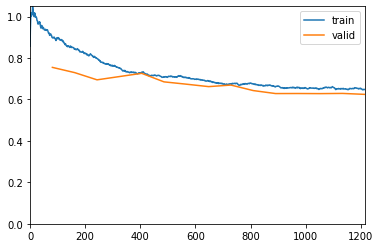

Better model found at epoch 1 with valid_loss value: 0.7293444871902466.
Better model found at epoch 2 with valid_loss value: 0.6945958733558655.
Better model found at epoch 5 with valid_loss value: 0.6847805976867676.
Better model found at epoch 6 with valid_loss value: 0.6736038327217102.
Better model found at epoch 7 with valid_loss value: 0.6618264317512512.
Better model found at epoch 9 with valid_loss value: 0.6427363157272339.
Better model found at epoch 10 with valid_loss value: 0.6283516883850098.
Better model found at epoch 12 with valid_loss value: 0.6281027793884277.
Better model found at epoch 14 with valid_loss value: 0.6244331002235413.


In [42]:
learn.fine_tune(15,freeze_epochs=2)

In [43]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

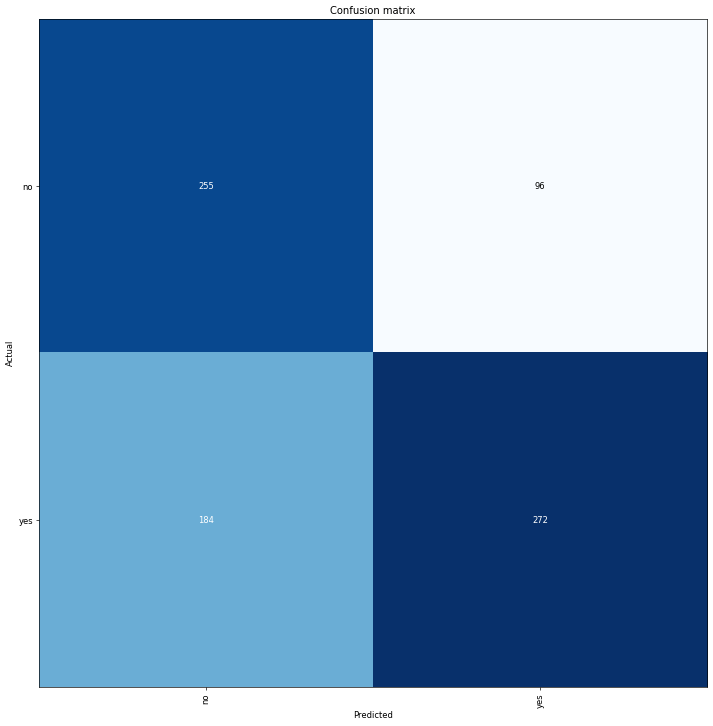

In [44]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [45]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6530359387397766.


(#4) [0.6127185821533203,0.6530359387397766,0.7391304347826086,0.5964912280701754]

## Ranger + Flat cosin Anneal

In [46]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.409573,1.041420,0.470948,0.495822,0.518950,00:24
1,1.266416,0.988497,0.486239,0.509859,0.527697,00:24


Better model found at epoch 0 with valid_loss value: 1.0414196252822876.


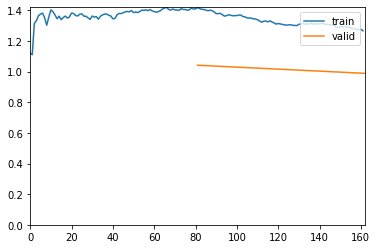

Better model found at epoch 1 with valid_loss value: 0.9884971380233765.


In [47]:
learn.fit_flat_cos(2,lr=1e-3)

In [48]:
learn.unfreeze()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=9.12010818865383e-07)

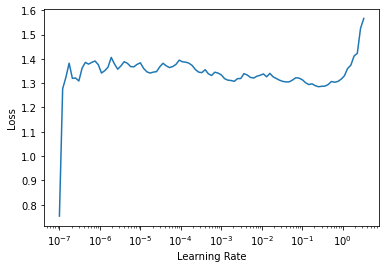

In [49]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.211127,0.849866,0.507645,0.529915,0.542274,00:26
1,1.102991,0.798488,0.522936,0.570136,0.367347,00:26
2,0.979316,0.741864,0.541284,0.584314,0.434402,00:27
3,0.870502,0.714049,0.538226,0.576779,0.448980,00:27
4,0.796049,0.707408,0.558104,0.597826,0.481050,00:27
5,0.745563,0.691704,0.564220,0.597315,0.518950,00:26
6,0.729934,0.678732,0.570336,0.593373,0.574344,00:27
7,0.697148,0.670404,0.585627,0.597297,0.644315,00:27
8,0.685038,0.664937,0.599388,0.600000,0.708455,00:27
9,0.676786,0.662245,0.602446,0.610080,0.670554,00:27


Better model found at epoch 0 with valid_loss value: 0.8498660922050476.


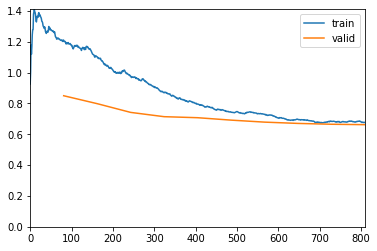

Better model found at epoch 1 with valid_loss value: 0.7984883189201355.
Better model found at epoch 2 with valid_loss value: 0.7418637871742249.
Better model found at epoch 3 with valid_loss value: 0.7140489816665649.
Better model found at epoch 4 with valid_loss value: 0.7074078321456909.
Better model found at epoch 5 with valid_loss value: 0.6917038559913635.
Better model found at epoch 6 with valid_loss value: 0.67873215675354.
Better model found at epoch 7 with valid_loss value: 0.6704035997390747.
Better model found at epoch 8 with valid_loss value: 0.6649366021156311.
Better model found at epoch 9 with valid_loss value: 0.6622447371482849.


In [50]:
learn.fit_flat_cos(10,lr=1e-2)

In [51]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [52]:
learn.dls = dlsTest

In [53]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6220570206642151.


(#4) [0.6463523507118225,0.6220570206642151,0.6616702355460385,0.6776315789473685]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [54]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.394799,1.003842,0.503058,0.529221,0.475219,00:25
1,1.362927,0.978241,0.500000,0.526316,0.466472,00:25


Better model found at epoch 0 with valid_loss value: 1.0038419961929321.


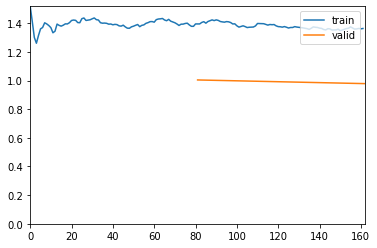

Better model found at epoch 1 with valid_loss value: 0.9782407879829407.


In [55]:
learn.fit_flat_cos(2,lr=1e-3)

In [56]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.630780702224001e-05)

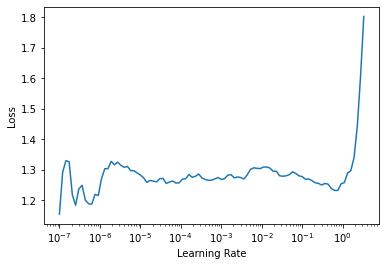

In [57]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.243593,0.878298,0.498471,0.530864,0.376093,00:27
1,1.087488,0.761861,0.518349,0.544586,0.498542,00:27
2,0.954280,0.773307,0.535168,0.570397,0.460641,00:27
3,0.870037,0.684779,0.597859,0.606952,0.661808,00:27
4,0.801874,0.688022,0.551988,0.576220,0.551020,00:27
5,0.749636,0.689085,0.564220,0.576316,0.638484,00:27
6,0.723914,0.693838,0.558104,0.568528,0.653061,00:27


Better model found at epoch 0 with valid_loss value: 0.8782981634140015.


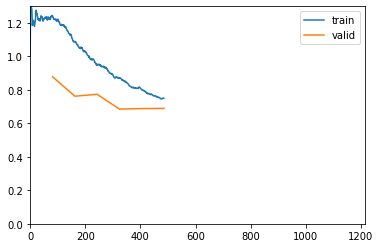

Better model found at epoch 1 with valid_loss value: 0.7618613243103027.
Better model found at epoch 3 with valid_loss value: 0.6847790479660034.
No improvement since epoch 3: early stopping


In [58]:
learn.fit_flat_cos(15,lr=1e-2)

In [59]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [60]:
learn.dls = dlsTest

In [61]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5427509546279907.


(#4) [0.7001919746398926,0.5427509546279907,0.5931477516059958,0.6074561403508771]

## Ranger +Flat + Label + MixUp

In [68]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.384820,1.052167,0.496942,0.536082,0.303207,00:25
1,1.343966,1.025922,0.487768,0.519417,0.311953,00:25


Better model found at epoch 0 with valid_loss value: 1.0521665811538696.


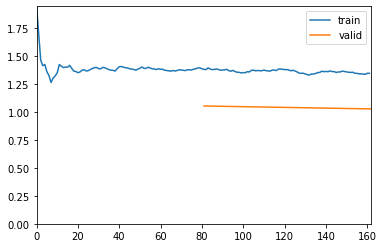

Better model found at epoch 1 with valid_loss value: 1.0259219408035278.


In [69]:
learn.fit_flat_cos(2,lr=1e-3)

In [70]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.230837,0.867769,0.495413,0.520900,0.472303,00:27
1,1.096802,0.766739,0.562691,0.591054,0.539359,00:27
2,0.992795,0.731866,0.539755,0.582677,0.431487,00:27
3,0.886821,0.728962,0.521407,0.537688,0.623907,00:27
4,0.806087,0.686614,0.565749,0.611321,0.472303,00:27
5,0.765703,0.679562,0.556575,0.579104,0.565598,00:27
6,0.739648,0.693308,0.536697,0.562500,0.524781,00:27
7,0.713695,0.686127,0.567278,0.574627,0.673469,00:27
8,0.704046,0.685516,0.558104,0.563981,0.693878,00:27


Better model found at epoch 0 with valid_loss value: 0.8677687048912048.


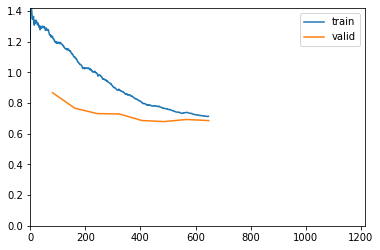

Better model found at epoch 1 with valid_loss value: 0.7667391300201416.
Better model found at epoch 2 with valid_loss value: 0.7318661212921143.
Better model found at epoch 3 with valid_loss value: 0.7289621829986572.
Better model found at epoch 4 with valid_loss value: 0.6866136193275452.
Better model found at epoch 5 with valid_loss value: 0.6795617341995239.
No improvement since epoch 5: early stopping


In [71]:
learn.fit_flat_cos(15,lr=1e-2)

In [72]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

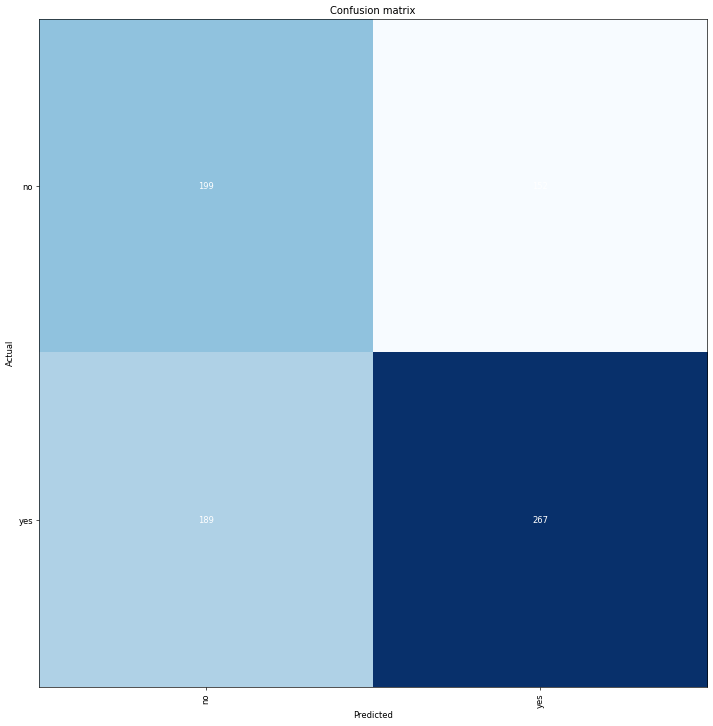

In [73]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [74]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5774473547935486.


(#4) [0.6802210211753845,0.5774473547935486,0.6372315035799523,0.5855263157894737]

## Ranger + Flat + MixUp

In [81]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [82]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.298210,0.942807,0.518349,0.537037,0.591837,00:25
1,1.277866,0.934284,0.524465,0.540609,0.620991,00:25


Better model found at epoch 0 with valid_loss value: 0.9428070783615112.


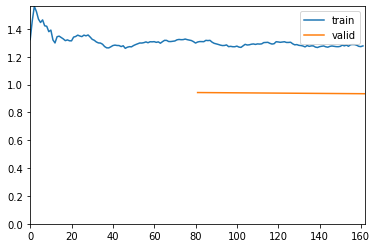

Better model found at epoch 1 with valid_loss value: 0.9342841506004333.


In [83]:
learn.fit_flat_cos(2,lr=1e-3)

In [84]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.221757,0.778691,0.587156,0.598916,0.644315,00:27
1,1.102133,0.772860,0.541284,0.566563,0.533528,00:27
2,0.987030,0.744396,0.541284,0.544513,0.766764,00:27
3,0.892478,0.707136,0.533639,0.579832,0.402332,00:27
4,0.811320,0.686423,0.564220,0.592357,0.542274,00:27
5,0.754746,0.693240,0.559633,0.584615,0.553936,00:27
6,0.728881,0.676869,0.558104,0.600746,0.469388,00:27
7,0.716057,0.687656,0.551988,0.602459,0.428571,00:27
8,0.702488,0.681450,0.562691,0.583578,0.580175,00:27
9,0.701531,0.679028,0.556575,0.592982,0.492711,00:27


Better model found at epoch 0 with valid_loss value: 0.7786909341812134.


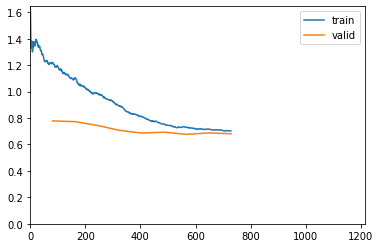

Better model found at epoch 1 with valid_loss value: 0.7728597521781921.
Better model found at epoch 2 with valid_loss value: 0.7443959712982178.
Better model found at epoch 3 with valid_loss value: 0.707135796546936.
Better model found at epoch 4 with valid_loss value: 0.686423122882843.
Better model found at epoch 6 with valid_loss value: 0.67686927318573.
No improvement since epoch 6: early stopping


In [85]:
learn.fit_flat_cos(15,lr=1e-2)

In [86]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [87]:
learn.dls = dlsTest

In [88]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.551425039768219.


(#4) [0.6811548471450806,0.551425039768219,0.6398809523809523,0.47149122807017546]

## Ranger + MixUp

In [93]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [94]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.335196,1.060780,0.481651,0.506711,0.440233,00:25
1,1.296730,0.986664,0.496942,0.522876,0.466472,00:25


Better model found at epoch 0 with valid_loss value: 1.0607802867889404.


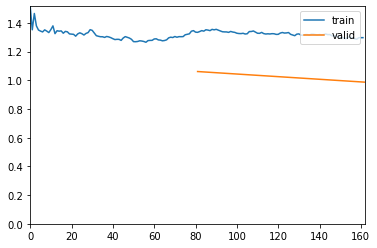

Better model found at epoch 1 with valid_loss value: 0.9866644740104675.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.247296,1.005549,0.490826,0.515625,0.481050,00:27
1,1.265866,0.978358,0.501529,0.527869,0.469388,00:27
2,1.240857,0.966299,0.493884,0.519108,0.475219,00:27
3,1.233195,0.949619,0.498471,0.524590,0.466472,00:27
4,1.209645,0.924694,0.490826,0.513966,0.536443,00:27
5,1.200610,0.892482,0.501529,0.525223,0.516035,00:27
6,1.132799,0.885360,0.503058,0.524590,0.559767,00:27
7,1.163218,0.873234,0.503058,0.526012,0.530612,00:27
8,1.111414,0.874848,0.492355,0.516320,0.507289,00:27
9,1.118490,0.859075,0.524465,0.549080,0.521866,00:27


Better model found at epoch 0 with valid_loss value: 1.0055493116378784.


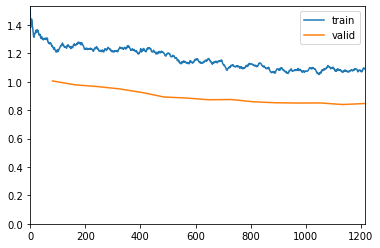

Better model found at epoch 1 with valid_loss value: 0.9783583879470825.
Better model found at epoch 2 with valid_loss value: 0.9662991762161255.
Better model found at epoch 3 with valid_loss value: 0.9496194124221802.
Better model found at epoch 4 with valid_loss value: 0.9246943593025208.
Better model found at epoch 5 with valid_loss value: 0.8924824595451355.
Better model found at epoch 6 with valid_loss value: 0.8853599429130554.
Better model found at epoch 7 with valid_loss value: 0.8732339143753052.
Better model found at epoch 9 with valid_loss value: 0.8590754270553589.
Better model found at epoch 10 with valid_loss value: 0.8519744277000427.
Better model found at epoch 11 with valid_loss value: 0.8500545620918274.
Better model found at epoch 13 with valid_loss value: 0.8395411968231201.


In [95]:
learn.fine_tune(15,freeze_epochs=2)

In [96]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [97]:
learn.dls = dlsTest

In [98]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.54027259349823.


(#4) [0.7566514611244202,0.54027259349823,0.5981524249422633,0.5679824561403509]

## Faltten + MixUp

In [104]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.186811,0.860216,0.558104,0.571809,0.626822,00:25
1,0.995038,0.763820,0.555046,0.646067,0.335277,00:25


Better model found at epoch 0 with valid_loss value: 0.8602157831192017.


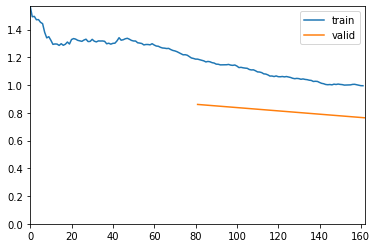

Better model found at epoch 1 with valid_loss value: 0.7638195157051086.


In [105]:
learn.fit_flat_cos(2,lr=1e-3)

In [106]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.107149,1.120422,0.493884,0.525862,0.355685,00:27
1,1.059344,0.731076,0.475535,0.000000,0.000000,00:26
2,1.221908,0.969965,0.524465,0.524465,1.000000,00:27
3,1.049650,2.723044,0.503058,0.521951,0.623907,00:26
4,0.906353,11.706367,0.475535,0.000000,0.000000,00:27


Better model found at epoch 0 with valid_loss value: 1.1204224824905396.


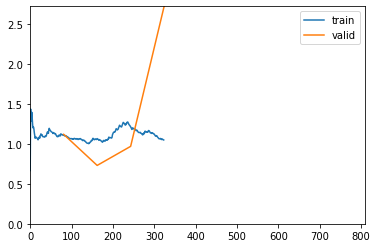

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with valid_loss value: 0.7310757637023926.
No improvement since epoch 1: early stopping


In [107]:
learn.fit_flat_cos(10,lr=1e-2)

In [108]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [109]:
learn.dls = dlsTest

In [110]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7493751049041748,0.4349442422389984,0.0,0.0]

## Ranger + Label

In [128]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [129]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.339094,1.007577,0.515290,0.527660,0.723032,00:25
1,1.296234,0.954815,0.509174,0.524887,0.676385,00:25


Better model found at epoch 0 with valid_loss value: 1.0075771808624268.


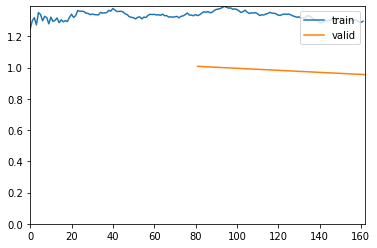

Better model found at epoch 1 with valid_loss value: 0.9548153877258301.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.286168,0.932196,0.501529,0.520581,0.626822,00:27
1,1.318852,0.923546,0.496942,0.517327,0.609329,00:27
2,1.248693,0.909736,0.487768,0.510695,0.556851,00:27
3,1.246182,0.892960,0.510703,0.529563,0.600583,00:27
4,1.194732,0.873236,0.500000,0.522599,0.539359,00:27
5,1.190738,0.865139,0.492355,0.514905,0.553936,00:27
6,1.170975,0.844323,0.492355,0.516035,0.516035,00:27
7,1.124206,0.833913,0.515290,0.534211,0.591837,00:27
8,1.127382,0.832624,0.509174,0.530556,0.556851,00:27
9,1.083779,0.825088,0.504587,0.526027,0.559767,00:27


Better model found at epoch 0 with valid_loss value: 0.9321964979171753.


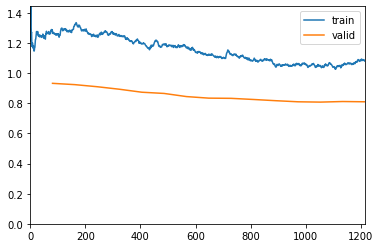

Better model found at epoch 1 with valid_loss value: 0.9235458970069885.
Better model found at epoch 2 with valid_loss value: 0.9097357392311096.
Better model found at epoch 3 with valid_loss value: 0.8929598927497864.
Better model found at epoch 4 with valid_loss value: 0.8732362985610962.
Better model found at epoch 5 with valid_loss value: 0.8651388883590698.
Better model found at epoch 6 with valid_loss value: 0.8443227410316467.
Better model found at epoch 7 with valid_loss value: 0.8339131474494934.
Better model found at epoch 8 with valid_loss value: 0.8326244354248047.
Better model found at epoch 9 with valid_loss value: 0.825088381767273.
Better model found at epoch 10 with valid_loss value: 0.8169782161712646.
Better model found at epoch 11 with valid_loss value: 0.8097000122070312.
Better model found at epoch 12 with valid_loss value: 0.8076003193855286.


In [130]:
learn.fine_tune(15,freeze_epochs=2)

In [131]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [132]:
learn.dls = dlsTest

In [133]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5390334725379944.


(#4) [0.7866721749305725,0.5390334725379944,0.6024390243902439,0.5416666666666666]

## Faltten + Label

In [134]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.285481,0.834627,0.529052,0.545220,0.615160,00:25
1,1.017348,0.729568,0.553517,0.585284,0.510204,00:25


Better model found at epoch 0 with valid_loss value: 0.8346272706985474.


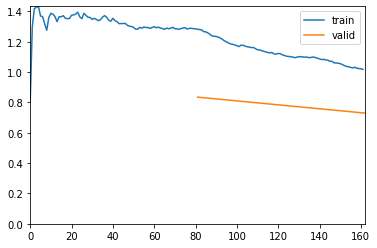

Better model found at epoch 1 with valid_loss value: 0.7295676469802856.


In [135]:
learn.fit_flat_cos(2,lr=1e-3)

In [136]:
learn.unfreeze()

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=1.9054607491852948e-06)

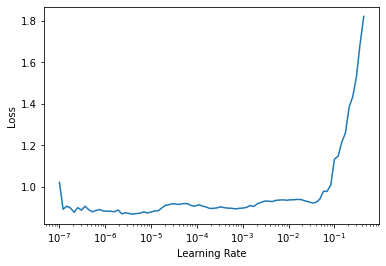

In [137]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.052807,1.039909,0.521407,0.523659,0.967930,00:27
1,1.002078,18.995140,0.475535,0.500000,0.002915,00:27
2,0.951344,1.516349,0.464832,0.468468,0.151603,00:26
3,0.974181,0.965868,0.527523,0.526899,0.970845,00:26
4,0.981066,19.916153,0.477064,0.506329,0.116618,00:26
5,0.983451,13.066996,0.472477,0.495455,0.317784,00:26
6,0.963686,52.374020,0.538226,0.537071,0.865889,00:27


Better model found at epoch 0 with valid_loss value: 1.0399094820022583.


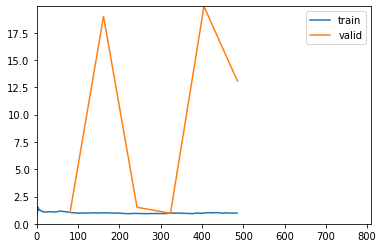

Better model found at epoch 3 with valid_loss value: 0.965867817401886.
No improvement since epoch 3: early stopping


In [138]:
learn.fit_flat_cos(10,lr=1e-2)

In [139]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [140]:
learn.dls = dlsTest

In [141]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5600991249084473.


(#4) [0.856486976146698,0.5600991249084473,0.5646606914212549,0.9671052631578947]

## Label + MixUp

In [142]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.187548,1.016217,0.503058,0.556962,0.256560,00:24
1,1.061995,0.844428,0.515290,0.526749,0.746356,00:25


Better model found at epoch 0 with valid_loss value: 1.0162172317504883.


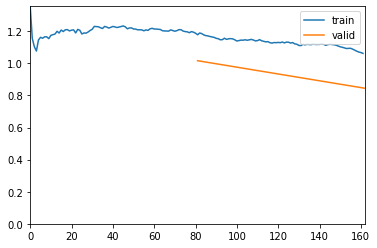

Better model found at epoch 1 with valid_loss value: 0.8444279432296753.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.848163,0.711657,0.539755,0.548837,0.688047,00:27
1,0.795836,0.711803,0.550459,0.583618,0.498542,00:27
2,0.764377,0.689226,0.555046,0.559908,0.708455,00:26
3,0.735639,0.683562,0.570336,0.575610,0.688047,00:27
4,0.713512,0.687472,0.579511,0.570248,0.804665,00:26
5,0.711553,0.679979,0.558104,0.584375,0.545190,00:27
6,0.694279,0.662149,0.634557,0.643646,0.679300,00:27
7,0.693882,0.674595,0.585627,0.631387,0.504373,00:27
8,0.694374,0.664709,0.625382,0.670139,0.562682,00:26
9,0.681846,0.662880,0.605505,0.660377,0.510204,00:26


Better model found at epoch 0 with valid_loss value: 0.7116574048995972.


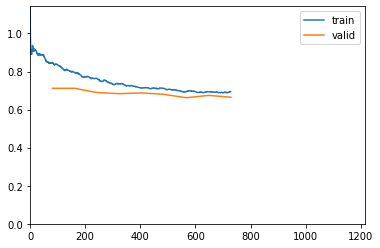

Better model found at epoch 2 with valid_loss value: 0.6892263889312744.
Better model found at epoch 3 with valid_loss value: 0.6835619211196899.
Better model found at epoch 5 with valid_loss value: 0.6799792051315308.
Better model found at epoch 6 with valid_loss value: 0.6621491312980652.
No improvement since epoch 6: early stopping


In [143]:
learn.fine_tune(15,freeze_epochs=2)

In [144]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [145]:
learn.dls = dlsTest

In [146]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6158612370491028.


(#4) [0.6645943522453308,0.6158612370491028,0.6666666666666666,0.6403508771929824]